In [ ]:
#Here is the list of all library i imported for the project
from google.colab import drive
from bs4 import BeautifulSoup
import requests

!pip install scikit-learn
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import seaborn as sns
!pip install xgboost
import xgboost as xgb
!pip install vadersentiment
!pip install textblob

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import lightgbm as lgb
from lightgbm import LGBMClassifier

import os

import torch
from transformers import BertTokenizer, BertModel
import pandas as pd

!pip install sentence_transformers
!pip install pandas nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import sentence_transformers
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as grf
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#CODE FOR WEB SCRAPPING NEWS TITLE OF APPLE COMPANY FROM MARKET INSIDER
url = 'https://markets.businessinsider.com/news/aapl-stock'
bh=[]

#I have scrapped 390 pages of information for the Apple stock
for i in range(1,390) :
  url2=url+'?p='+str(i)
  res = requests.get(url2)
  html = res.text
  soup = BeautifulSoup(html,'lxml')
  columns = ['datetime','title']
  df=pd.DataFrame(columns=columns)

#From the appropriate class,i have extracted useful textual data
  articles= soup.find_all('div',class_='latest-news__story')
  for article in articles:
    datetime = article.find('time',class_='latest-news__date').get('datetime')
    title = article.find('a',class_='news-link').text
    bh.append([datetime,title])
    df=pd.DataFrame(bh,columns=df.columns)
df['date'] = pd.to_datetime(df['datetime']).dt.date
drive.mount('drive', force_remount = True)

#Csv sheet is created to add these data in respective column and saved in drive

df.to_csv('df.csv')
!cp df.csv "drive/My Drive/"

<ipython-input-2-b47deb2b51c4>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['datetime']).dt.date


Mounted at drive


In [ ]:
#Edition are made in csv file to merge all news of same date into one entry only

bl = pd.read_csv('df.csv')
df2 = bl.groupby('date')['title'].apply(''.join).reset_index()
print(df2)

            date                                              title
0     2013-02-25  Apple signals emerging-market rethink with Ind...
1     2013-03-01  Judge throws out part of Apple patent award ag...
2     2013-03-06  Samsung gets a foot in at key Apple supplier S...
3     2013-03-07  Analysis: Next Intel CEO to guide new business...
4     2013-03-09  U.S. judge will not suspend Apple vs. Samsung ...
...          ...                                                ...
2952  2024-06-13  Why This Analyst Thinks Broadcom Will Be the N...
2953  2024-06-14  Inflation Cools In May, Fed Hints At Slower Pa...
2954  2024-06-15  PayPal falls the most among financial stocks, ...
2955  2024-06-16  Some fintechs will suffer, some will gain from...
2956  2024-06-17  TDK Announces Wearable Battery Breakthrough Te...

[2957 rows x 2 columns]


In [ ]:
#This is written for tokenising and cleaning new title of Apple Stock

lemmatizer = WordNetLemmatizer()
def clean_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words]
    #It removes all all stop words from news title

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalpha() and word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)
#Formation of a new column for cleaned title text which has final outcome of cleaning

df2['cleaned_title'] = df2['title'].apply(clean_text)
print(df2)

            date                                              title  \
0     2013-02-25  Apple signals emerging-market rethink with Ind...   
1     2013-03-01  Judge throws out part of Apple patent award ag...   
2     2013-03-06  Samsung gets a foot in at key Apple supplier S...   
3     2013-03-07  Analysis: Next Intel CEO to guide new business...   
4     2013-03-09  U.S. judge will not suspend Apple vs. Samsung ...   
...          ...                                                ...   
2952  2024-06-13  Why This Analyst Thinks Broadcom Will Be the N...   
2953  2024-06-14  Inflation Cools In May, Fed Hints At Slower Pa...   
2954  2024-06-15  PayPal falls the most among financial stocks, ...   
2955  2024-06-16  Some fintechs will suffer, some will gain from...   
2956  2024-06-17  TDK Announces Wearable Battery Breakthrough Te...   

                                          cleaned_title  
0                       apple signal rethink india push  
1     judge throw part apple pa

In [ ]:
#Below code is for transforming textual cleaned title text into vector by running it on Word2vec

sentences = df2['cleaned_title'].apply(lambda x: x.split()).tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
#Defining of word2vec function for transformation

def word2vec(words, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index_to_key)
    for word in words:
        if word in index2word_set:
            nwords += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if nwords > 0:
        feature_vec = np.divide(feature_vec, nwords)
    return feature_vec
num_features = 100
#Added column named features which has vectors obtained via above defined function

df2['Word2Vec_Features'] = df2['cleaned_title'].apply(lambda x: word2vec(x, model, num_features))
print(df2[['title', 'Word2Vec_Features']])

                                                  title  \
0     Apple signals emerging-market rethink with Ind...   
1     Judge throws out part of Apple patent award ag...   
2     Samsung gets a foot in at key Apple supplier S...   
3     Analysis: Next Intel CEO to guide new business...   
4     U.S. judge will not suspend Apple vs. Samsung ...   
...                                                 ...   
2952  Why This Analyst Thinks Broadcom Will Be the N...   
2953  Inflation Cools In May, Fed Hints At Slower Pa...   
2954  PayPal falls the most among financial stocks, ...   
2955  Some fintechs will suffer, some will gain from...   
2956  TDK Announces Wearable Battery Breakthrough Te...   

                                      Word2Vec_Features  
0     [0.059993863, 0.60193557, 0.382367, 0.13742593...  
1     [0.020988913, 0.48796952, 0.31118825, 0.107263...  
2     [0.014672521, 0.44710547, 0.2848692, 0.0964111...  
3     [-0.0021982966, 0.3424658, 0.2140545, 0.067422...  
4

In [ ]:
#It is important to set hugging face token as an Environment Variable
#below is code for it (authenticating access to Hugging Face Model)

os.environ['HF_TOKEN'] = 'collab'
#Defining a function to add more feature with the help of FinBERT model

def FinBERT_Feature(text, model, tokenizer):
    #Transforms text into tensors (tokenize)

    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    feature_vector = last_hidden_state.mean(dim=1).cpu().numpy().flatten()
    return feature_vector
finbert_model = BertModel.from_pretrained('yiyanghkust/finbert-tone')
finbert_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
#Adding column to save FinBERT feature extracted from cleaned title text

df2['FinBERT_Features'] = df2['cleaned_title'].apply(lambda text: FinBERT_Feature(text, finbert_model, finbert_tokenizer))
finbert_feature = pd.DataFrame(df2['FinBERT_Features'].to_list(), columns=[f'FinBERT_{i}' for i in range(len(df2['FinBERT_Features'][0]))])
word2vec_feature = pd.DataFrame(df2['Word2Vec_Features'].to_list(), columns=[f'Word2Vec_{i}' for i in range(len(df2['Word2Vec_Features'][0]))])
final_data4 = pd.concat([df2, finbert_feature, word2vec_feature], axis=1)
final_data4.drop(['FinBERT_Features', 'Word2Vec_Features'], axis=1, inplace=True)
print(final_data4)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

            date                                              title  \
0     2013-02-25  Apple signals emerging-market rethink with Ind...   
1     2013-03-01  Judge throws out part of Apple patent award ag...   
2     2013-03-06  Samsung gets a foot in at key Apple supplier S...   
3     2013-03-07  Analysis: Next Intel CEO to guide new business...   
4     2013-03-09  U.S. judge will not suspend Apple vs. Samsung ...   
...          ...                                                ...   
2952  2024-06-13  Why This Analyst Thinks Broadcom Will Be the N...   
2953  2024-06-14  Inflation Cools In May, Fed Hints At Slower Pa...   
2954  2024-06-15  PayPal falls the most among financial stocks, ...   
2955  2024-06-16  Some fintechs will suffer, some will gain from...   
2956  2024-06-17  TDK Announces Wearable Battery Breakthrough Te...   

                                          cleaned_title  FinBERT_0  FinBERT_1  \
0                       apple signal rethink india push   0.607126

In [ ]:
#Finding subjectivity and polarity using textblob and vader for sentiment analysis on news title

final_data4 ['Subjectivity'] = final_data4 ['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
final_data4 ['Polarity'] = final_data4 ['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)

sid = SentimentIntensityAnalyzer()
#Defining a function for sentiment Score

def get_sentiment_scores(text):
    return sid.polarity_scores(text)
sentiment_scores = final_data4['cleaned_title'].apply(get_sentiment_scores)
#Added 4 columns in csv for Sentiment Analysis using Vader

final_data4 ['negative'] = sentiment_scores.apply(lambda x: x['neg'])
final_data4 ['positive'] = sentiment_scores.apply(lambda x: x['pos'])
final_data4 ['neutral'] = sentiment_scores.apply(lambda x: x['neu'])
final_data4 ['compound'] = sentiment_scores.apply(lambda x: x['compound'])

#Saving all the creations made into new file df2 which is saved to drive

drive.mount('drive', force_remount = True)
final_data4 .to_csv('df2.csv')
!cp df2.csv "drive/My Drive/"
final_data4.head(50)

Mounted at drive


,date,title,cleaned_title,FinBERT_0,FinBERT_1,FinBERT_2,FinBERT_3,FinBERT_4,FinBERT_5,FinBERT_6,...,Word2Vec_96,Word2Vec_97,Word2Vec_98,Word2Vec_99,Subjectivity,Polarity,negative,positive,neutral,compound
0,2013-02-25,Apple signals emerging-market rethink with Ind...,apple signal rethink india push,0.607126,-0.909610,-0.303204,1.097272,-0.083112,0.339127,-0.465277,...,0.201141,-0.655563,-0.059852,-0.161080,0.000000,0.000000,0.000,0.000,1.000,0.0000
1,2013-03-01,Judge throws out part of Apple patent award ag...,judge throw part apple patent award samsungjud...,-0.077137,0.443713,0.473390,0.822381,1.171707,-0.674295,-0.189831,...,0.190630,-0.538938,-0.052682,-0.137603,0.000000,0.000000,0.158,0.328,0.514,0.6486
2,2013-03-06,Samsung gets a foot in at key Apple supplier S...,samsung get foot key apple supplier sharp mill...,0.193727,-0.976911,-0.154816,1.378916,0.022490,-0.986486,0.723924,...,0.178790,-0.497631,-0.049036,-0.120843,0.875000,-0.062500,0.000,0.000,1.000,0.0000
3,2013-03-07,Analysis: Next Intel CEO to guide new business...,analysis next intel ceo guide new business may...,0.093931,-0.099146,0.138874,0.708204,0.914799,-1.065298,-0.512156,...,0.137595,-0.385100,-0.046723,-0.086628,0.227273,0.068182,0.000,0.000,1.000,0.0000
4,2013-03-09,U.S. judge will not suspend Apple vs. Samsung ...,judge suspend apple samsung case,-0.218558,-0.111093,0.101862,0.615136,1.091761,-1.324495,-0.839716,...,0.281048,-0.743282,-0.064333,-0.214062,0.000000,0.000000,0.365,0.000,0.635,-0.3182
5,2013-03-13,"Trade panel delays decision on Apple, Samsung ...",trade panel delay decision apple samsung paten...,0.991298,0.063952,0.245375,0.597301,-0.134568,-1.401995,-0.258351,...,0.223138,-0.528047,-0.050960,-0.143657,0.000000,0.000000,0.141,0.000,0.859,-0.3182
6,2013-03-16,Samsung Galaxy S4 blitz may prompt Apple rethink,samsung galaxy blitz may prompt apple rethink,0.465068,-0.605568,-0.108533,0.708298,0.023270,0.081576,-0.036018,...,0.213248,-0.564941,-0.068864,-0.126111,0.000000,0.000000,0.000,0.000,1.000,0.0000
7,2013-03-19,"Samsung working on wristwatch, joins Apple: so...",samsung working wristwatch join apple source,0.146324,-0.951295,-0.564024,1.067301,0.833731,-0.920010,0.274596,...,0.217782,-0.459187,-0.045406,-0.134043,0.000000,0.000000,0.000,0.306,0.694,0.2960
8,2013-03-21,Apple investors pay more for downside bets,apple investor pay downside bet,-0.287557,0.131386,0.683132,0.693073,1.367072,0.044489,-0.397528,...,0.084512,-0.375912,-0.043195,-0.066950,0.000000,0.000000,0.531,0.000,0.469,-0.3400
9,2013-03-22,Apple investors pay more for downside bets,apple investor pay downside bet,-0.287557,0.131386,0.683132,0.693073,1.367072,0.044489,-0.397528,...,0.084512,-0.375912,-0.043195,-0.066950,0.000000,0.000000,0.531,0.000,0.469,-0.3400


In [ ]:
                                        #NOTE#

#Extracted some numerical data(open,high,close,low,etc) available online from certain websites
#This data file was then saved in Drive

#Reading the data from a file saved in drive
#Merging the numerical Data of Apple Stocks with the textual data of same data,merging data of two files

fpath = 'drive/MyDrive/apple_data_online.csv'
f2path = 'drive/MyDrive/df2.csv'
k1 = pd.read_csv(fpath)
k2 = pd.read_csv(f2path)
k1['date'] = pd.to_datetime(k1['date'])
k2['date'] = pd.to_datetime(k2['date'])
merged_df = pd.merge(k2, k1, on='date')
#Saving this all merged data in New file

merged_path = 'drive/MyDrive/Okbhai.csv'
merged_df.to_csv(merged_path, index=False)
merged_df.head()

In [ ]:
#Here i am selecting specific column oF Okbhai.csv to create new dataframe
#Below are two newly created Dataframe

merged_df2=merged_df.drop(columns=['High','Low','Close','cleaned_title','title','date','Unnamed: 7','Unnamed: 0'])
merged_df1=merged_df[['Open','High','Low','Close','Volume','Polarity','Subjectivity','negative','positive','neutral','Label']]
print(merged_df2)

      FinBERT_0  FinBERT_1  FinBERT_2  FinBERT_3  FinBERT_4  FinBERT_5  \
0      0.607126  -0.909610  -0.303204   1.097272  -0.083112   0.339127   
1     -0.077137   0.443713   0.473390   0.822381   1.171707  -0.674295   
2      0.193727  -0.976911  -0.154816   1.378916   0.022490  -0.986486   
3      0.093931  -0.099146   0.138874   0.708204   0.914799  -1.065298   
4      0.991298   0.063952   0.245375   0.597301  -0.134568  -1.401995   
...         ...        ...        ...        ...        ...        ...   
2336  -0.114872  -0.022596   0.569720  -0.069728   0.870414   0.766001   
2337  -0.528179  -0.487411   1.122625   0.651872   0.381401  -0.894293   
2338  -0.126308  -0.320056   0.591156   0.852986   0.727855  -0.637876   
2339  -0.068149  -0.629717   0.682684   0.741955   0.957220  -0.559053   
2340   0.128929  -0.640597   0.809176  -0.040423   0.602871   0.197417   

      FinBERT_6  FinBERT_7  FinBERT_8  FinBERT_9  ...  Subjectivity  Polarity  \
0     -0.465277   0.052646  -0

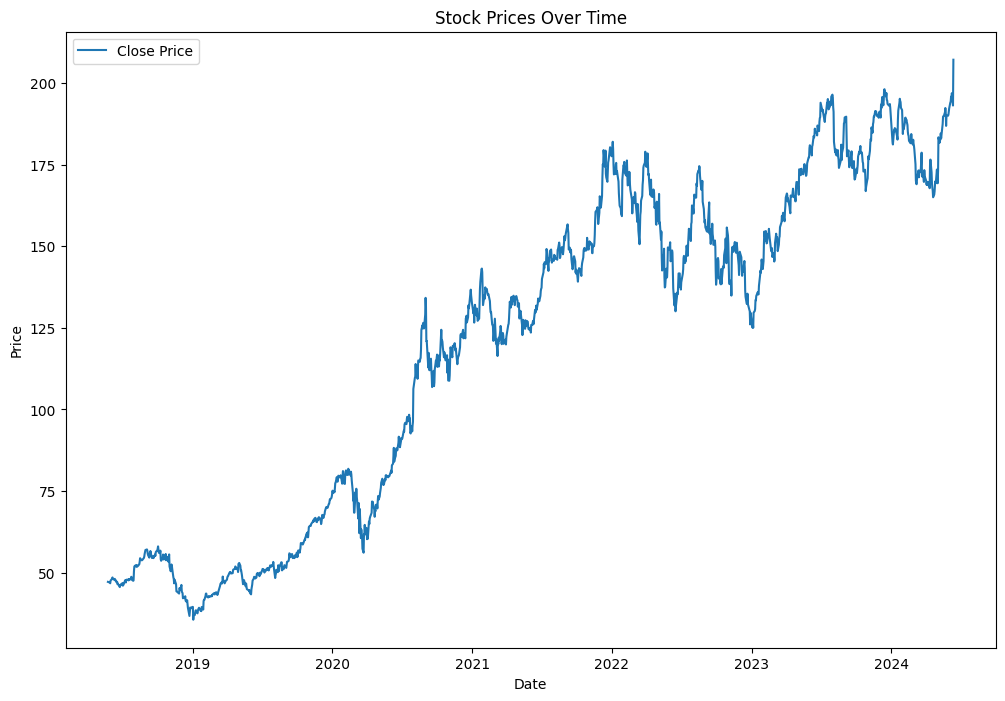

In [ ]:
#Here i have written the code to obtain graph of Stock Prices Over Time
#On X axis we have date and on Y axis we have Close Price of Apple Stock for that date

subset_df = merged_df.tail(1500)
grf.figure(figsize=(12, 8))
grf.plot(subset_df['date'], subset_df['Close'], label='Close Price')
grf.title('Stock Prices Over Time')
grf.xlabel('Date')
grf.ylabel('Price')
grf.legend()
grf.show()

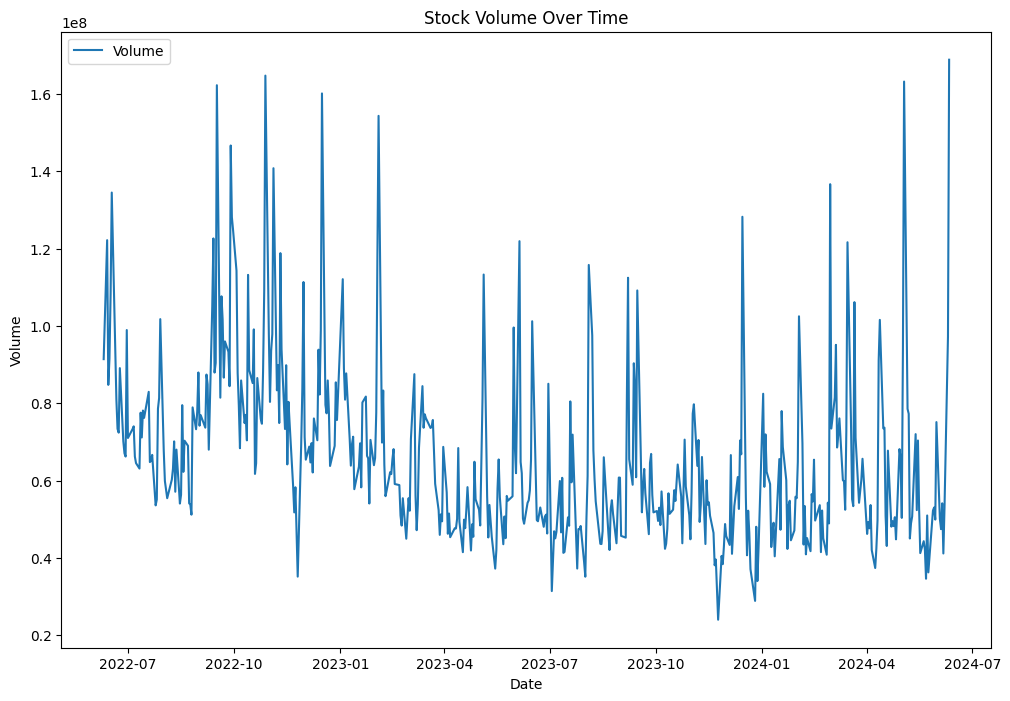

In [ ]:
#Here i have written the code to obtain graph of Stock Volume Over Time
#On X axis we have date and on Y axis we have Volume of Apple Stock for that date

subset_df = merged_df.tail(500)
grf.figure(figsize=(12, 8))
grf.plot(subset_df['date'], subset_df['Volume'], label='Volume')
grf.title('Stock Volume Over Time')
grf.xlabel('Date')
grf.ylabel('Volume')
grf.legend()
grf.show()

In [ ]:
                                        #NOTE#

#FROM HERE ON WE ARE TRAINING 3 DIFFERENT FINE TUNED ML MODELS
#FURTHER WE WILL ENSEMBLE THEM TO GET THE BEST ML MODEL USING BEST PARAMETER AND HAVING BETTER ACCURACY

                                      # MODEL-1 #
# Logistic Regression

X=merged_df2.drop(['Label'],axis=1)
y=merged_df2['Label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=42)
#For fine tuning i am using hyper parameter tuning with grid search
param={
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
    }
model1 = LogisticRegression()
grid= GridSearchCV(estimator=model1, param_grid=param, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)
print("Best parameters found: ", grid.best_params_)
best_logreg = grid.best_estimator_
y_pred = best_logreg.predict(X_test)

#Below is the code for printing results of Model-1
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'C': 0.1, 'max_iter': 100, 'solver': 'newton-cg'}
Accuracy: 0.7897727272727273
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       159
           1       0.80      0.82      0.81       193

    accuracy                           0.79       352
   macro avg       0.79      0.79      0.79       352
weighted avg       0.79      0.79      0.79       352



In [ ]:

                                      # MODEL-2 #
# ADA Boost

X = merged_df2.drop(['Label'], axis=1)
y = merged_df2['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#For fine tuning i am using hyper parameter tuning with grid search

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}
base_estimator = DecisionTreeClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42,algorithm='SAMME')
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_ada_model = grid_search.best_estimator_
y_pred = best_ada_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#Below is the code for printing results of Model-1

print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'learning_rate': 1.0, 'n_estimators': 200}
Accuracy: 0.47547974413646055
              precision    recall  f1-score   support

           0       0.40      0.44      0.42       203
           1       0.54      0.50      0.52       266

    accuracy                           0.48       469
   macro avg       0.47      0.47      0.47       469
weighted avg       0.48      0.48      0.48       469



In [ ]:
                                      # MODEL-3 #

# Linear Discriminant Analysis Model

X = merged_df2.drop(['Label'], axis=1)
y = merged_df2['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lda = LinearDiscriminantAnalysis()
#For fine tuning i am using hyper parameter tuning with grid search

param_grid = {'solver': [ 'lsqr', 'eigen'],'shrinkage': [None, 'auto'] + list(np.linspace(0, 1, 10))}
grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_lda = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")
y_pred = best_lda.predict(X_test)
#Below is the code for printing results of Model-3

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best parameters found: {'shrinkage': None, 'solver': 'eigen'}
Accuracy: 0.6609808102345416
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       203
           1       0.69      0.72      0.71       266

    accuracy                           0.66       469
   macro avg       0.65      0.65      0.65       469
weighted avg       0.66      0.66      0.66       469



In [ ]:
# Here i am ensembling the 3 ML models for getting better Output

#Ensemble Model

X = merged_df2.drop(['Label'], axis=1)
y = merged_df2['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
ensemble=VotingClassifier(estimators=[('lr',best_logreg),('ada',best_ada_model),('lda',lda)],voting='soft')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

#Below is the code for printing results of Ensemble Model
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:311: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


0.7249466950959488
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       213
           1       0.74      0.77      0.75       256

    accuracy                           0.72       469
   macro avg       0.72      0.72      0.72       469
weighted avg       0.72      0.72      0.72       469



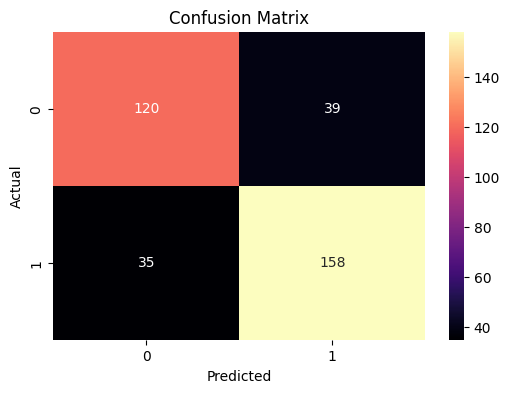

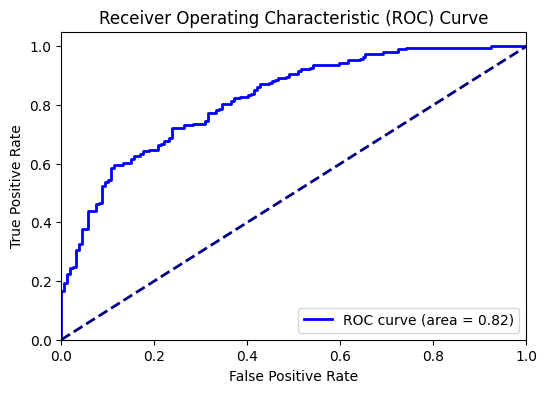

In [ ]:
#Here is the code for getting Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
grf.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
grf.xlabel('Predicted')
grf.ylabel('Actual')
grf.title('Confusion Matrix')
grf.show()
ensemble=VotingClassifier(estimators=[('lr',best_logreg),('ada',best_ada_model),('lda',lda)],voting='soft')
ensemble.fit(X_train, y_train)
y_prob = ensemble.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
#Here is the code for getting ROC Curve

grf.figure(figsize=(6, 4))
grf.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
grf.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
grf.xlim([0.0, 1.0])
grf.ylim([0.0, 1.05])
grf.xlabel('False Positive Rate')
grf.ylabel('True Positive Rate')
grf.title('Receiver Operating Characteristic (ROC) Curve')
grf.legend(loc="lower right")
grf.show()

In [ ]:
# Convert y_pred to a Pandas Series with the same index as X_test
y_pred_series = pd.Series(y_pred, index=X_test.index, name='Predicted_Label')

# Now you can merge
result_df = pd.merge(X_test, y_pred_series, left_index=True, right_index=True)
final_df = pd.merge(result_df,merged_df, on=['Adj Close','Volume'],how='inner')
final_df=final_df.drop(['Unnamed: 0','Unnamed: 7'],axis=1)
print(final_df)
drive.mount('drive', force_remount = True)

#Csv sheet is created to add these data in respective column and saved in drive

final_df.to_csv('final_pred.csv')
!cp final_pred.csv "drive/My Drive/"

     FinBERT_0_x  FinBERT_1_x  FinBERT_2_x  FinBERT_3_x  FinBERT_4_x  \
0      -0.354802     0.114584     0.324559     1.023762     0.996944   
1       0.141936    -0.602320     0.938359     0.752875     0.323389   
2      -0.164684     0.144608    -1.209534    -0.005097     0.781013   
3       0.261761     0.600995     0.430071     0.647929     0.641603   
4      -0.239500    -0.427760     0.504602     0.889487     0.488647   
..           ...          ...          ...          ...          ...   
347    -0.359079    -0.174972     0.644716     0.957684     0.184311   
348     0.017496    -0.819626     0.730001     1.251602     0.645003   
349    -0.357696    -0.748769     1.256250     0.600166     0.691385   
350     0.195071    -0.259971    -0.152261     0.754595     0.578998   
351     0.392415    -0.778509     0.903615     0.885726     1.260280   

     FinBERT_5_x  FinBERT_6_x  FinBERT_7_x  FinBERT_8_x  FinBERT_9_x  ...  \
0       0.016919    -0.578884    -0.728873    -0.892981   